# Working with Structured Grids as Unstructured Grids

In this notebook, we explore working with curvilinear structured grid with an unstructured representation. We are interested in expressing the interpolation of c-grid velocity on a curvilinear grid using a `uxarray.Grid` object. The purpose of doing this is to explore the possibility of representing all data in Parcels as unstructured grid data. For validation, we aim to reproduce the interpolation of a velocity field on an aqua-planet NEMO data set (see https://docs.oceanparcels.org/en/latest/examples/tutorial_nemo_curvilinear.html for a complete description)

## Loading in the example data set

In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import parcels

example_dataset_folder = parcels.download_example_dataset("NemoCurvilinear_data")
dsm = xr.open_dataset(f"{example_dataset_folder}/mesh_mask.nc4")
dsm = dsm.squeeze(drop=True) 
dsm = dsm.isel( x=slice(10,-10), y=slice(10,-10) )

# make sure there's actual labels for the original x and y
dsm = dsm.assign_coords(x=list(range(dsm.sizes["x"])), y=list(range(dsm.sizes["y"])))
dsm


<xarray.Dataset> Size: 114MB
Dimensions:  (y: 1001, x: 1422)
Coordinates:
  * x        (x) int64 11kB 0 1 2 3 4 5 6 ... 1415 1416 1417 1418 1419 1420 1421
  * y        (y) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999 1000
Data variables:
    fmask    (y, x) float32 6MB ...
    tmask    (y, x) float32 6MB ...
    umask    (y, x) float32 6MB ...
    vmask    (y, x) float32 6MB ...
    glamf    (y, x) float64 11MB ...
    glamt    (y, x) float64 11MB ...
    glamu    (y, x) float64 11MB ...
    glamv    (y, x) float64 11MB ...
    gphif    (y, x) float64 11MB ...
    gphit    (y, x) float64 11MB ...
    gphiu    (y, x) float64 11MB ...
    gphiv    (y, x) float64 11MB ...
Attributes:
    Conventions:                GDT 1.2
    file_name:                  mask.nc 
    TimeStamp:                  2006-JUL-23 08:24:52 GMT+0200
    history:                    Thu Nov 23 17:15:00 2017: ncks -A -v glamt,gp...
    NCO:                        20171123
    history_of_appended_files:  Thu Nov 23 17:15:00 2017: Appended file Thu N...

## Describing a structured curvilinear grid as an unstructured grid

In our initial attempts to read in structured grid data with `uxarray.from_structured_grid`, we found that `uxarray` does not support curvilinear grids, where the `x` and `y` coordinates are dependent on two indices. Because of this, we spend some time mapping the curvilinear grid coordinates to a UGRID compliant `xarray.dataset`; see [xugrid documentation](https://deltares.github.io/xugrid/examples/quick_overview.html#from-xarray-dataset) for more background on this. Essentially, we need to 

* Flatten the latitude and longitude vorticity points to 1-D array and store each as data variables `node_lat` and `node_lon`, respectively, with dimension `node`. In NEMO, these are the `gphif` and `glamf` data variables.
* Create a `node` coordinate that is a integer list of node ids
* Define the connectivity information between "faces", which are synomous with tracer cells on a c-grid, and the corner nodes. Ultimately, this information is stored in a data variable called `face_node_connectivity` which has dimensions `(n_face,nmax_face)`, where `n_face` is the number of "faces" (tracer points) and `nmax_face` is the max number of nodes per face. For the structured grid, `nmax_face=4`.


In [2]:
xuds = xr.Dataset()
xuds = xuds.assign(node_lon=(("node", ),dsm.glamf.stack(node=["x", "y"]).data))
xuds = xuds.assign(node_lat=(("node", ),dsm.gphif.stack(node=["x", "y"]).data))
xuds = xuds.assign_coords(node=(("node", ), list(range(xuds.sizes["node"]))))

# Now we construct face node connectivity
dsm_minus_WS = dsm.isel(x=slice(1, None), y=slice(1, None))

x_node_offsets = xr.DataArray([-1, 0, 0, -1], dims=("node", ), coords={"node": ["ll", "lr", "ur", "ul"]})
y_node_offsets = xr.DataArray([-1, -1, 0, 0], dims=("node", ), coords={"node": ["ll", "lr", "ur", "ul"]})
x_nodes = (xr.broadcast(dsm_minus_WS.x, dsm_minus_WS.y)[0] + x_node_offsets).rename("x_nodes")
y_nodes = (xr.broadcast(dsm_minus_WS.x, dsm_minus_WS.y)[1] + y_node_offsets).rename("y_nodes")

mesh_nodes = xr.Dataset()
mesh_nodes = mesh_nodes.assign(glamf=dsm.glamf.stack(node=["x", "y"]))
mesh_nodes = mesh_nodes.assign(gphif=dsm.gphif.stack(node=["x", "y"]))
mesh_nodes = mesh_nodes.assign_coords(node_id=(("node", ), list(range(mesh_nodes.sizes["node"]))))
mesh_nodes

mesh_elements = xr.Dataset()
mesh_elements = mesh_elements.assign(node_id=mesh_nodes.unstack().node_id.sel(x=x_nodes, y=y_nodes))
mesh_elements = mesh_elements.rename({"node_id": "node_id_in_element"})
mesh_elements = mesh_elements.assign_coords(
    x=mesh_elements.x.sel(node="ur", drop=True).isel(y=0, drop=True),
    y=mesh_elements.y.sel(node="ur", drop=True).isel(x=0, drop=True),
)
mesh_elements = mesh_elements.stack(element=["x", "y"])
mesh_elements = mesh_elements.drop_vars(["x", "y"])

xuds = xuds.assign(face_node_connectivity=(("n_face","nmax_face", ),mesh_elements.node_id_in_element.transpose().data))
xuds


/tmp/ipykernel_18914/1188425333.py:28: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'element'} to avoid an error in the future.
  mesh_elements = mesh_elements.drop_vars(["x", "y"])


<xarray.Dataset> Size: 80MB
Dimensions:                 (node: 1423422, n_face: 1421000, nmax_face: 4)
Coordinates:
  * node                    (node) int64 11MB 0 1 2 ... 1423419 1423420 1423421
Dimensions without coordinates: n_face, nmax_face
Data variables:
    node_lon                (node) float64 11MB 75.38 75.38 ... 72.74 72.77
    node_lat                (node) float64 11MB -76.41 -76.35 ... 50.48 50.48
    face_node_connectivity  (n_face, nmax_face) int64 45MB 0 1001 ... 1422420

## Converting to uxarray.Grid

Once we have the UGRID compliant `xarray.Dataset` , we can construct a `uxarray.Grid` from this object. This gives us the benefit of being able to use all the generated connectivity fields, cartesian coordinate calculations, etc. included with `uxarray`. Additionally, we now have a datastructure that can be used with our previously constructured spatial hashing methods.

In [3]:
import uxarray

uxgrid = uxarray.Grid(xuds,source_grid_spec='UGRID')
uxgrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_face: 1421000
  * n_nodes_per_face: (1421000,)
Grid Coordinates (Spherical):
  * node_lon: (1423422,)
  * node_lat: (1423422,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (1421000, 4)
Grid Descriptor Variables:
  * n_nodes_per_face: (1421000,)

## Constructing the hash grid
From here, we need to verify that the spatial hashing method works with quadrilateral grids. We start by constructing the hash grid and relating the NEMO grid cells to the hash grid

In [ ]:
import uxarray 
from typing import Union
import numpy as np


def calculate_hash_cell_size(uxobj: Union[uxarray.UxDataset, uxarray.Grid], scalefac: float = 1.0):
    """
    Calculate the hash cell size using the median edge length as a characteristic length scale. The characteristic
    length scale is optionally scaled by the provided `scalefac` parameter to obtain the hash cell grid size.
    At the moment, the hash cell size is returned in units of degrees.
    
    Parameters:
    - uxobj (uxarray.UXDataSet or uxarray.Grid type) : uxarray object containing the grid either as a Grid or UXDataSet
    - scalefac (float): Multiplier for the median triangle diagonal length to set the hash cell size
    
    Returns:
    - cell_size (float): The recommended hash cell size.
    """
    import numpy as np

    if isinstance(uxobj, uxarray.UxDataset):
        grid = uxobj.uxgrid
    elif isinstance(uxobj, uxarray.Grid):
        grid = uxobj
    else:
        raise TypeError(f"Unsupported type: {type(uxobj)}")

    # The uxarray grid.edge_node_distances method returns
    # the distances in units of degrees
    return grid.edge_node_distances.median().to_numpy()*180.0/np.pi*scalefac # Need to return the hash size in degrees


# Calculate hash cell size
hash_cell_size = calculate_hash_cell_size(uxgrid,0.5)
print( f"Hash cell size : {hash_cell_size}")

# Get the bounding box for the domain
x_max = uxgrid.node_lon.max().to_numpy()
x_min = uxgrid.node_lon.min().to_numpy()
y_max = uxgrid.node_lat.max().to_numpy()
y_min = uxgrid.node_lat.min().to_numpy()

# To determine how many hash cells we need, we divide the domain length by the hash_cell_size
Lx = (x_max-x_min)
Ly = (y_max-y_min)
print( f"Domain size (Lx,Ly) : ({Lx},{Ly})")
nxh = int(np.ceil(Lx/hash_cell_size))
nyh = int(np.ceil(Ly/hash_cell_size))
print( f"Number of hash cells (nxh,nyh) : ({nxh},{nyh})")




Hash cell size : 0.07546615600666834
Domain size (Lx,Ly) : (359.9960174560547,165.5464096069336)
Number of hash cells (nxh,nyh) : (4771,2194)


In [55]:
class hashgrid:
    def __init__(self, x_min, y_min, dh, nx, ny):
        self.x_min = x_min
        self.y_min = y_min
        self.dh = dh
        self.nx = nx
        self.ny = ny

hgrid = hashgrid(x_min,y_min,hash_cell_size,nxh,nyh)

In [ ]:
import numpy as np

def get_faces_in_hash_cells(uxobj: Union[uxarray.UxDataset, uxarray.Grid], hgrid):
    """
    Efficiently find the list of faces whose bounding box overlaps with the specified hash cells.
    
    Parameters:
    - uxobj (uxarray.UXDataSet or uxarray.Grid type) : uxarray object containing the grid either as a Grid or UXDataSet
    - xwest (float) : longitude of the western extent of the model domain
    - xeast (float) : longitude of the eastern extent of the model domain
    - nxh (int) : The number of hash cell vertices in the x-direction
    - nyh (int) : The number of hash cell vertices in the y-direction
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    
    Returns:
    - face_hashmap (dict): A dictionary where keys are the hash cell index and values are lists of triangle indices.
    """
    import numpy as np
    if isinstance(uxobj, uxarray.UxDataset):
        grid = uxobj.uxgrid
    elif isinstance(uxobj, uxarray.Grid):
        grid = uxobj
    else:
        raise TypeError(f"Unsupported type: {type(uxobj)}")
    
    face_hashmap = [[] for i in range(hgrid.nx*hgrid.ny)]

    lon_bounds = grid.face_bounds_lon.to_numpy()
    lat_bounds = grid.face_bounds_lat.to_numpy()

    # Loop over each face
    for eid in range(grid.n_face):
        
        # Calculate the bounding box of the face
        x_min = lon_bounds[eid,0]
        x_max = lon_bounds[eid,1]

        y_min = lat_bounds[eid,0]
        y_max = lat_bounds[eid,1]

        # Find the hash cell range that overlaps with the triangle's bounding box
        i_min = int(np.floor((x_min-hgrid.x_min) / hgrid.dh))
        i_max = int(np.floor((x_max-hgrid.x_min) / hgrid.dh))
        j_min = int(np.floor((y_min-hgrid.y_min) / hgrid.dh))
        j_max = int(np.floor((y_max-hgrid.y_min) / hgrid.dh))
        
        # Iterate over all hash cells that intersect the bounding box
        for j in range(j_min, j_max + 1):
            for i in range(i_min, i_max + 1):
                face_hashmap[i+nxh*j].append(eid)
                    
    return face_hashmap

import matplotlib.pyplot as plt


hashmap = get_faces_in_hash_cells(uxgrid,hgrid)



Minimum triangle count per hash cell : 0.0
Maximum triangle count per hash cell : 281.0
Median triangle count per hash cell  : 2.0
Number of non-empty hash cells       : 10244079 ( 97.86488254107398 %)


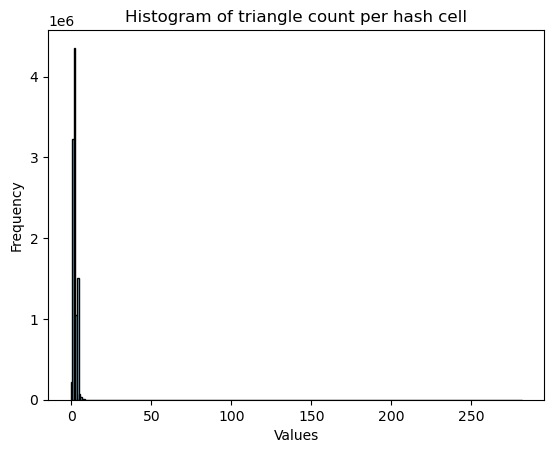

In [57]:
# ## Count how many triangles are in each hash cell.
hashmap_triangle_count = np.zeros(len(hashmap))
k=0
for t in hashmap:
    hashmap_triangle_count[k]=len(t)
    k+=1

nnonzero = np.count_nonzero(hashmap_triangle_count)
print(f"Minimum triangle count per hash cell : {np.min(hashmap_triangle_count)}")
print(f"Maximum triangle count per hash cell : {np.max(hashmap_triangle_count)}")
print(f"Median triangle count per hash cell  : {np.median(hashmap_triangle_count)}")
print(f"Number of non-empty hash cells       : {nnonzero} ( {nnonzero/len(hashmap)*100.0} %)")

# Plotting a basic histogram
bin_edges = np.arange( np.min(hashmap_triangle_count)-0.5, np.max(hashmap_triangle_count)+1.5,1)
values, bins, bars = plt.hist(hashmap_triangle_count, bins=bin_edges, color='skyblue', edgecolor='black',align='mid')
#plt.bar_label(bars, fontsize=13, color='navy')
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of triangle count per hash cell')
 
# Display the plot
plt.show()

## Computing computational coordinates

To support quadrilateral elements, we need to create methods that compute the computational coordinates for a curvilinear quadrilateral. To find the computational coordinates, we essentially need to invert the equation

$$
\begin{equation}
 \vec{x}(\vec{\xi})_{k} = \vec{x}_p
\end{equation}
$$

where $\vec{x}_p$ is the position of a particle, and $\vec{x}(\vec{\xi})$ is the bilinear mapping function for the quadrilateral element $k$ to the reference square. The index $k$ is found using the spatial hashing lookup table. A Newton's iterative solver is used to compute the estimated computational coordinates. If the computational coordinates are outside the range $[0,1]$, we instead search the next element in the hash table lookup; this is repeated until a valid computational coordinate is found within the list of elements in the spatial hash table lookup.



In [79]:
import math

def X_map( lon, lat, xsi, eta ):
    """Computes the physical coordinates for an element, given the computational coordinates"""

    x = (1.0-xsi)*(1.0-eta)*lon[0]+(xsi)*(1.0-eta)*lon[1]+xsi*eta*lon[2]+(1.0-xsi)*eta*lon[3]
    y = (1.0-xsi)*(1.0-eta)*lat[0]+(xsi)*(1.0-eta)*lat[1]+xsi*eta*lat[2]+(1.0-xsi)*eta*lat[3]
    
    return x,y

def covariant( lon, lat, xsi, eta ):
    """Computes each component of each of the covariant basis vectors"""

    dxdxsi = -(1.0-eta)*lon[0]+(1.0-eta)*lon[1]+eta*lon[2]-eta*lon[3]
    dxdeta = -(1.0-xsi)*lon[0]-(xsi)*lon[1]+xsi*lon[2]+(1.0-xsi)*lon[3]
    dydxsi = -(1.0-eta)*lat[0]+(1.0-eta)*lat[1]+eta*lat[2]-eta*lat[3]
    dydeta = -(1.0-xsi)*lat[0]-(xsi)*lat[1]+xsi*lat[2]+(1.0-xsi)*lat[3]

    return dxdxsi, dxdeta, dydxsi, dydeta

# This is a modification of the search indices method
def get_element_id(uxgrid,y,x,hash_x_min, hash_y_min, hash_cell_size):

    # Get the particle hash
    i = int(np.floor( (x-hash_x_min) / hash_cell_size))
    j = int(np.floor( (y-hash_y_min) / hash_cell_size))
    hashid = i+nxh*j
    tol = 1e-8
    maxiter = 1e5
    print( f"{hashmap[hashid]}")
    for eid in hashmap[hashid]:
        node_ids = uxgrid.face_node_connectivity[eid,:]
        lat = uxgrid.node_lat[node_ids]
        lon = uxgrid.node_lon[node_ids]
        
        # Newton solve
        # Initial guess
        xsi = 0.5
        eta = 0.5
        iter = 0
        while True:
            # x,y position from computational coordinates
            xg,yg = X_map( lon, lat, xsi, eta )
            # Residual
            rx = x-xg
            ry = y-yg
            # Covariant matrix
            dxdxsi, dxdeta, dydxsi, dydeta = covariant( lon, lat, xsi, eta )
            # Determinant = Jacobian of the transform
            J = dxdxsi*dydeta-dxdeta*dydxsi

            dxsi = (dydeta*rx - dxdeta*ry)/J
            deta = (dxdxsi*ry - dydeta*rx)/J
            xsi += dxsi
            eta += deta
            mag = np.sqrt(dxsi**2 + deta**2)
            if ( mag < tol ):
                break

            if iter > maxiter:
                break
            iter+=1

        inside_face = all( [xsi >= 0.0, xsi <= 1.0, 
                            eta >= 0.0, eta <= 1.0 ] )
        if inside_face:
            return eta, xsi, eid
        
    # If we reach this point, the point was not found within a face in the grid
    return -1.0, -1.0, -1 # Return values that indicate an error

def _geodetic_distance(lat1: float, lat2: float, lon1: float, lon2: float, lat: float) -> float:
    rad = np.pi / 180.0
    deg2m = 1852 * 60.0
    return np.sqrt(((lon2 - lon1) * deg2m * math.cos(rad * lat)) ** 2 + ((lat2 - lat1) * deg2m) ** 2)

def phi2D_lin(eta: float, xsi: float) -> list[float]:
    phi = [(1-xsi) * (1-eta),
              xsi  * (1-eta),
              xsi  *    eta ,
           (1-xsi) *    eta ]

    return phi

def spatial_c_grid_interpolation2D(uxDataset, uxgrid, z, y, x, hash_x_min,hash_y_min, hash_cell_size, applyConversion=True):
    import math

    eta, xsi, eid = get_element_id(uxgrid,y,x,hash_x_min,hash_y_min, hash_cell_size) # Example/demo routine
    node_ids = uxgrid.face_node_connectivity[eid,:]
    px = uxgrid.node_lon[node_ids]
    py = uxgrid.node_lat[node_ids]

    px[0] = px[0] + 360 if px[0] < x - 225 else px[0]
    px[0] = px[0] - 360 if px[0] > x + 225 else px[0]
    px[1:] = np.where(px[1:] - px[0] > 180, px[1:] - 360, px[1:])
    px[1:] = np.where(-px[1:] + px[0] > 180, px[1:] + 360, px[1:])
        
    xx = (1 - xsi) * (1 - eta) * px[0] + xsi * (1 - eta) * px[1] + xsi * eta * px[2] + (1 - xsi) * eta * px[3]
    assert abs(xx - x) < 1e-4
    c1 = _geodetic_distance(py[0], py[1], px[0], px[1], np.dot(phi2D_lin(0.0, xsi), py))
    c2 = _geodetic_distance(py[1], py[2], px[1], px[2], np.dot(phi2D_lin(eta, 1.0), py))
    c3 = _geodetic_distance(py[2], py[3], px[2], px[3], np.dot(phi2D_lin(1.0, xsi), py))
    c4 = _geodetic_distance(py[3], py[0], px[3], px[0], np.dot(phi2D_lin(eta, 0.0), py))

    U0 = uxDataset.U.data[uxgrid.face_node_connectivity[eid,3]] * c4
    U1 = uxDataset.U.data[uxgrid.face_node_connectivity[eid,2]] * c2
    V0 = uxDataset.V.data[uxgrid.face_node_connectivity[eid,1]] * c1
    V1 = uxDataset.V.data[uxgrid.face_node_connectivity[eid,2]] * c3

    U = (1 - xsi) * U0 + xsi * U1
    V = (1 - eta) * V0 + eta * V1
    rad = np.pi / 180.0
    deg2m = 1852 * 60.0
    if applyConversion:
        meshJac = (deg2m * deg2m * math.cos(rad * y)) #if grid.mesh == "spherical" else 1
    else:
        meshJac = deg2m #if grid.mesh == "spherical" else 1

    # Covariant matrix
    dxdxsi, dxdeta, dydxsi, dydeta = covariant( px, py, xsi, eta )
    # Determinant = Jacobian of the transform
    jac = (dxdxsi*dydeta-dxdeta*dydxsi)*meshJac

    u = (dxdxsi*U + dxdeta*V)/jac
    v = (dydxsi*U + dydeta*V)/jac

    return (u, v)

## Interpolating vector fields
Since NEMO and other models that work with curvilinear grids report the $U$ and $V$ velocity components in the contravariant basis vector directions (across coordinate lines), the interpolated vector $(U,V)$ is rotated to the longitude and latitude directions after interpolation. 

The example below follows the same example documented in the Parcels tutorials at https://docs.oceanparcels.org/en/latest/examples/tutorial_nemo_curvilinear.html wherein we verify that we can indeed produce the correct longitude and latitude components of the velocity field on a curvilinear NEMO grid.

In [80]:
# Load in u and v field
dsu = xr.open_dataset(f"{example_dataset_folder}/U_purely_zonal-ORCA025_grid_U.nc4",decode_times=False)
dsu = dsu.squeeze(drop=True) 
dsu = dsu.isel( x=slice(10,-10), y=slice(10,-10) )

dsv = xr.open_dataset(f"{example_dataset_folder}/V_purely_zonal-ORCA025_grid_V.nc4",decode_times=False)
dsv = dsv.squeeze(drop=True) 
dsv = dsv.isel( x=slice(10,-10), y=slice(10,-10) )

ds = xr.Dataset()
ds = ds.assign(U=(("node", ),dsu.U.stack(node=["x", "y"]).data))
ds = ds.assign(V=(("node", ),dsv.V.stack(node=["x", "y"]).data))
ds

u, v = spatial_c_grid_interpolation2D(ds, uxgrid, 0, 60, 50, x_min, y_min, hash_cell_size, applyConversion=False)
print(f"(u, v) = ({u:.3f}, {v:.3f})")
assert np.isclose(u, 1.0, atol=1e-3)

[1283886, 1284885, 1284886]
<xarray.DataArray ()> Size: 8B
array(0.46018388) <xarray.DataArray ()> Size: 8B
array(0.06303755) 1284886
(u, v) = (1.000, -0.000)
